In [420]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize

# Data Cleaning & EDA

Pre-cleaning notes
- Need to remove rows which include [deleted] in comment
- Need to remove rows which include '# Message to all users...'
- Delete ones which have [removed]
- Remove ones that start with 'Welcome'
- Remove NaN
- Removing the various ways people use markdown shortcuts in reddit comments
    - https://www.reddit.com/wiki/markdown/

- NLTK
    - Lemmatizer
    - StopWords


In [421]:
real = pd.read_csv('reddit_ai_df.csv')

In [422]:
real.head()

,title,top_comment,answers
0,How can I purposely get clumps in my spaghetti,I’ve actually done this before. \n\nTie a whol...,sauce?\n\n1. Use a potato masher to mash the ...
1,"Rabbit hole engaged... 11,082 cookbooks in dig...",Brewster Kahle is the man responsible for this...,\n\nThere are actually a few digital collectio...
2,"Hello everybody, I’m Maangchi! I have a Korean...",Hello Maangchi! I've followed your channel sin...,NaN
3,UPDATE: I prepared Japanese A5 Wagyu Steak for...,This is my favorite type of update post! All t...,!\n\nThank you so much for your help! I really...
4,Instacart gave me 50 pounds of limes instead o...,[deleted],\n\nThere are many things you can do with 50 p...


In [423]:
real.shape

(3751, 3)

In [424]:
#Start index at 1 instead of 0
#https://www.includehelp.com/python/pandas-start-row-index-from-1-instead-of-zero-without-creating-additional-column.aspx
real.index = np.arange(1, len(real) + 1)

In [425]:
#Rename index to row_id
#https://saturncloud.io/blog/how-to-name-your-pandas-index-column-a-guide-for-data-scientists/#:~:text=Method%201%3A%20Using%20the%20rename_axis()%20Method&text=In%20this%20example%2C%20we%20first,index%20column%20to%20'person'.
real.rename_axis('row_id', inplace=True)

In [426]:
real.head()

,title,top_comment,answers
row_id,,,
1,How can I purposely get clumps in my spaghetti,I’ve actually done this before. \n\nTie a whol...,sauce?\n\n1. Use a potato masher to mash the ...
2,"Rabbit hole engaged... 11,082 cookbooks in dig...",Brewster Kahle is the man responsible for this...,\n\nThere are actually a few digital collectio...
3,"Hello everybody, I’m Maangchi! I have a Korean...",Hello Maangchi! I've followed your channel sin...,NaN
4,UPDATE: I prepared Japanese A5 Wagyu Steak for...,This is my favorite type of update post! All t...,!\n\nThank you so much for your help! I really...
5,Instacart gave me 50 pounds of limes instead o...,[deleted],\n\nThere are many things you can do with 50 p...


In [427]:
real.to_csv('final_dataframe.csv', index = False)

In [428]:
#Removing white space from all AI answers
#https://www.geeksforgeeks.org/pandas-strip-whitespace-from-entire-dataframe/
real['answers'] = real['answers'].str.strip()

In [429]:
#Drop rows with NaN
real = real.dropna()

In [430]:
#Drop rows which include [deleted] in top_comment
#https://stackoverflow.com/questions/18172851/deleting-dataframe-row-in-pandas-based-on-column-value
real = real[real.top_comment != '[deleted]']
real.shape

(3562, 3)

In [431]:
#Delete rows which have [removed] in top_comment
real = real[real.top_comment != '[removed]']
real.shape

(3539, 3)

In [432]:
#Remove ones that start with 'Welcome'
#Going to check how they start with Welcome
real[real['top_comment'].str.startswith('Welcome')]

,title,top_comment,answers
row_id,,,
874,Guys i feel like an idiot,Welcome to being a man make sure to stick it i...,.\n\nThat's okay. We all make mistakes sometim...
2381,Is it all about building the same mediocre pro...,Welcome to work. Unless you’re inventing somet...,"again?\n\nNo, it is not. Building the same med..."
3185,China has had almost zero recorded cases of co...,Welcome to r/TrueAskReddit. Remember that this...,Journalists are likely reporting on this topic...
3192,Is it all Carpe diem then?,Welcome to r/TrueAskReddit. Remember that this...,"No, not necessarily. Carpe diem is a Latin phr..."
3199,Why don't the Olympics maintain a single venue...,Welcome to r/TrueAskReddit. Remember that this...,"The Olympics are a global event, and maintaini..."
3210,If you are punished for being an efficient and...,Welcome to r/TrueAskReddit. Remember that this...,"No, it is not morally acceptable to stop givin..."
3214,"Today as an American, I constantly hear about ...",Welcome to r/TrueAskReddit. Remember that this...,1. Invest in infrastructure: Investing in our ...
3258,Is it better to teach your teens to be realist...,Welcome to r/TrueAskReddit. Remember that this...,"Yes, it is better to teach teens to be realist..."
3309,Why is child abuse on boys played for laughs i...,Welcome to r/TrueAskReddit. Remember that this...,Child abuse is often played for laughs in movi...


In [433]:
real.loc[3185, 'top_comment']

'Welcome to r/TrueAskReddit. Remember that this subreddit is aimed at high quality discussion, so please elaborate on your answer as much as you can and avoid off-topic or jokey answers as per [subreddit rules](https://www.reddit.com/r/TrueAskReddit/about/sidebar).\n\n*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/TrueAskReddit) if you have any questions or concerns.*'

In [434]:
#Deleting rows with the welcome message shown above
real = real[real.top_comment != 'Welcome to r/TrueAskReddit. Remember that this subreddit is aimed at high quality discussion, so please elaborate on your answer as much as you can and avoid off-topic or jokey answers as per [subreddit rules](https://www.reddit.com/r/TrueAskReddit/about/sidebar).\n\n*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/TrueAskReddit) if you have any questions or concerns.*']
real.shape

(3499, 3)

In [435]:
real.loc[2381, 'answers']

'again?\n\nNo, it is not. Building the same mediocre products over and over again is not the goal of product development; rather, the goal is to build innovative products that provide value to customers. Product development involves a continuous cycle of research, design, testing, and improvement to ensure that products are meeting customer needs and staying ahead of the competition.'

In [436]:
#I thought I deleted whitespace with .strip(), but I see \n\n in AI answers
#Will need to remove that
#https://www.w3schools.com/python/ref_string_replace.asp
real['answers'] = real['answers'].str.replace('\n\n', ' ')
real.loc[2381, 'answers']

'again? No, it is not. Building the same mediocre products over and over again is not the goal of product development; rather, the goal is to build innovative products that provide value to customers. Product development involves a continuous cycle of research, design, testing, and improvement to ensure that products are meeting customer needs and staying ahead of the competition.'

In [437]:
real.shape

(3499, 3)

In [438]:
#Checking for all markdown shortcuts given from reddit
#https://www.reddit.com/wiki/markdown/
#Will need to remove as raw string
#https://saturncloud.io/blog/how-to-count-occurrences-of-certain-words-in-pandas-dataframe/#:~:text=By%20using%20the%20str.,appear%20in%20a%20dataframe%20column.
#https://www.geeksforgeeks.org/python-raw-strings/
real['top_comment'].str.count(r'\*').sum()

6889

In [439]:
real['top_comment'].str.count(r'\n').sum()

13729

In [440]:
real['top_comment'].str.count(r'--').sum()

626

In [441]:
real['top_comment'].str.count(r'>!spoilers!<').sum()

0

In [442]:
real['top_comment'].str.count(r'superscript').sum()

0

In [443]:
real['top_comment'].str.count(r"'code'").sum()

0

In [444]:
real['top_comment'].str.count(r"u/reddit").sum()

30

In [445]:
real['top_comment'].str.count(r"# ").sum()

176

In [446]:
#Deletng all \n
real['top_comment'] = real['top_comment'].str.replace('\n', ' ')
real['top_comment'].str.count(r'\n').sum()

0

In [447]:
filterr = real[real['top_comment'].str.contains(r'--')]
#Not going to delete this as some people actually use this within their text to convey message

In [448]:
#Checking for u/reddit
filterr = real[real['top_comment'].str.contains('u/reddit')]

In [449]:
filterr.head(20)
#Going to have to delete all the below with that automated comment

,title,top_comment,answers
row_id,,,
1900,Referrals Are King - A Shithead Guide On Succe...,A recent Reddit policy change threatens to kil...,"1. Network, network, network. The best way to ..."
1989,"Years ago, I accidentally deleted the entire c...",A recent Reddit policy change threatens to kil...,"I knew I had made a terrible mistake, and I im..."
2028,Wow my team at Adobe put up a job offer for a ...,A recent Reddit policy change threatens to kil...,That's incredible! It speaks to the high quali...
2049,This sub is horrible for your mental health (s...,A recent Reddit policy change threatens to kil...,We understand that mental health is a very imp...
2051,I was laid-off/fired - UPDATE - junior who bro...,A recent Reddit policy change threatens to kil...,rules If you were laid off or fired for breaki...
2084,My manager got into a car crash while he was o...,A recent Reddit policy change threatens to kil...,If your manager was on a Zoom call while they ...
2174,Software Engineering isn't a backup career,A recent Reddit policy change threatens to kil...,"No, it is not. Software engineering is a highl..."
2176,"Replying to unsolicited recruiters with ""No fu...",A recent Reddit policy change threatens to kil...,Thank you for your interest in my skills and e...
2178,Made fun of during a live coding round for usi...,A recent Reddit policy change threatens to kil...,That's okay - everyone makes mistakes when cod...


In [450]:
real.loc[1900, 'top_comment']

"A recent Reddit policy change threatens to kill many beloved third-party mobile apps, making a great many quality-of-life features not seen in the official mobile app **permanently inaccessible** to users.  On May 31, 2023, Reddit announced they were raising the price to make calls to their API from being free to a level that will kill every third party app on Reddit, from [Apollo](https://www.reddit.com/r/apolloapp/comments/13ws4w3/had_a_call_with_reddit_to_discuss_pricing_bad/) to [Reddit is Fun](https://www.reddit.com/r/redditisfun/comments/13wxepd/rif_dev_here_reddits_api_changes_will_likely_kill/) to [Narwhal](https://www.reddit.com/r/getnarwhal/comments/13wv038/reddit_have_quoted_the_apollo_devs_a_ridiculous/jmdqtyt/) to [BaconReader](https://www.reddit.com/r/baconreader/comments/13wveb2/reddit_api_changes_and_baconreader/).  Even if you're not a mobile user and don't use any of those apps, this is a step toward killing other ways of customizing Reddit, such as Reddit Enhancemen

In [451]:
real = real[real.top_comment != f"A recent Reddit policy change threatens to kill many beloved third-party mobile apps, making a great many quality-of-life features not seen in the official mobile app **permanently inaccessible** to users.  On May 31, 2023, Reddit announced they were raising the price to make calls to their API from being free to a level that will kill every third party app on Reddit, from [Apollo](https://www.reddit.com/r/apolloapp/comments/13ws4w3/had_a_call_with_reddit_to_discuss_pricing_bad/) to [Reddit is Fun](https://www.reddit.com/r/redditisfun/comments/13wxepd/rif_dev_here_reddits_api_changes_will_likely_kill/) to [Narwhal](https://www.reddit.com/r/getnarwhal/comments/13wv038/reddit_have_quoted_the_apollo_devs_a_ridiculous/jmdqtyt/) to [BaconReader](https://www.reddit.com/r/baconreader/comments/13wveb2/reddit_api_changes_and_baconreader/).  Even if you're not a mobile user and don't use any of those apps, this is a step toward killing other ways of customizing Reddit, such as Reddit Enhancement Suite or the use of the old.reddit.com desktop interface .  This isn't only a problem on the user level: many subreddit moderators depend on tools only available outside the official app to keep their communities on-topic and spam-free.  &#x200B;  What can *you* do?  1. **Complain.** Message the mods of r/reddit.com, who are the admins of the site: message [/u/reddit](https://www.reddit.com/u/reddit/): submit a [support request](https://support.reddithelp.com/hc/en-us/requests/new): comment in relevant threads on [r/reddit](https://www.reddit.com/r/reddit/), such as [this one](https://www.reddit.com/r/reddit/comments/12qwagm/an_update_regarding_reddits_api/), leave a negative review on their official iOS or Android app- and sign your username in support to this post. 2. **Spread the word.** Rabble-rouse on related subreddits. Meme it up, make it spicy. Bitch about it to your cat. Suggest anyone you know who moderates a subreddit join us at our sister sub at [r/ModCoord](https://www.reddit.com/r/ModCoord/) \\- but please don't pester mods you *don't* know by simply spamming their modmail. 3. **Boycott** ***and*** **spread the word...to Reddit's competition!** Stay off Reddit as much as you can, instead, take to your favorite *non*\\-Reddit platform of choice and make some noise in support!   https://discord.gg/cscareerhub  https://programming.dev  4. **Don't be a jerk.** As upsetting this may be, threats, profanity and vandalism will be worse than useless in getting people on our side. Please make every effort to be as restrained, polite, reasonable and law-abiding as possible.   *I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/cscareerquestions) if you have any questions or concerns.*"]
real.shape

(3484, 3)

In [452]:
#Deleting all # with a space afterwards as represents header
real['top_comment'] = real['top_comment'].str.replace('# ', ' ')

In [453]:
#Setting up X and y
#Referred back to practice_clean_and_model to put it all steps into one cell


#New dataframe with answers from human, and 0 to represent human response
df1 = pd.DataFrame()
df1['answer'] = real['top_comment']
df1['who_from'] = 0

#New dataframe with answers from AI, and 1 to represent AI response
df2 = pd.DataFrame()
df2['answer'] = real['answers']
df2['who_from'] = 1

#Put df1 and df2 together
df = pd.concat([df1, df2])

#Need to fix row index
#https://pynative.com/pandas-reset-index/#:~:text=Use%20DataFrame.reset_index()%20function,-We%20can%20use&text=reset_index()%20to%20reset%20the,of%20numbers%20starting%20at%200.
df = df.reset_index()

#Drop rows with NaN (redundant)
df = df.dropna()

df.head(5000)

,row_id,answer,who_from
0,1,I’ve actually done this before. Tie a whole ...,0
1,2,Brewster Kahle is the man responsible for this...,0
2,4,This is my favorite type of update post! All t...,0
3,6,Oh I have been DYING to know how this worked o...,0
4,9,Thank you for all efforts for this culinary en...,0
...,...,...,...
4995,1579,The most common reason for fans having an odd ...,1
4996,1580,"It's possible that this is codespeak for ""Woul...",1
4997,1581,"If I were to go to prison, I envision my role ...",1
4998,1582,"This is difficult to answer definitively, as i...",1


In [454]:
df.shape

(6968, 3)

In [455]:
#https://medium.com/analytics-vidhya/using-natural-language-processing-in-python-to-conduct-your-own-social-listening-f0e6bda47aee
#EDA: Going to look at top used words between Reddit and OpenAI

In [456]:
#Instantiate CVEC while excluding stop words
cvec = CountVectorizer(stop_words='english')
#Fit to column
cvec.fit(real['top_comment'])
#Transform column
top_comments = cvec.transform(real['top_comment'])
#Dataframe with transformed data
df_reddit_cvec = pd.DataFrame(top_comments.todense(), columns = cvec.get_feature_names_out())
df_reddit_cvec

,00,000,000th,001,0031,01,02282014160921,03,04,0488,...,zoomed,zoos,zorgon,zucchini,µm,étuvée,привет,参匠,醤油屋,수능
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3479,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3480,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3481,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3482,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Text(0, 0.5, 'Word')

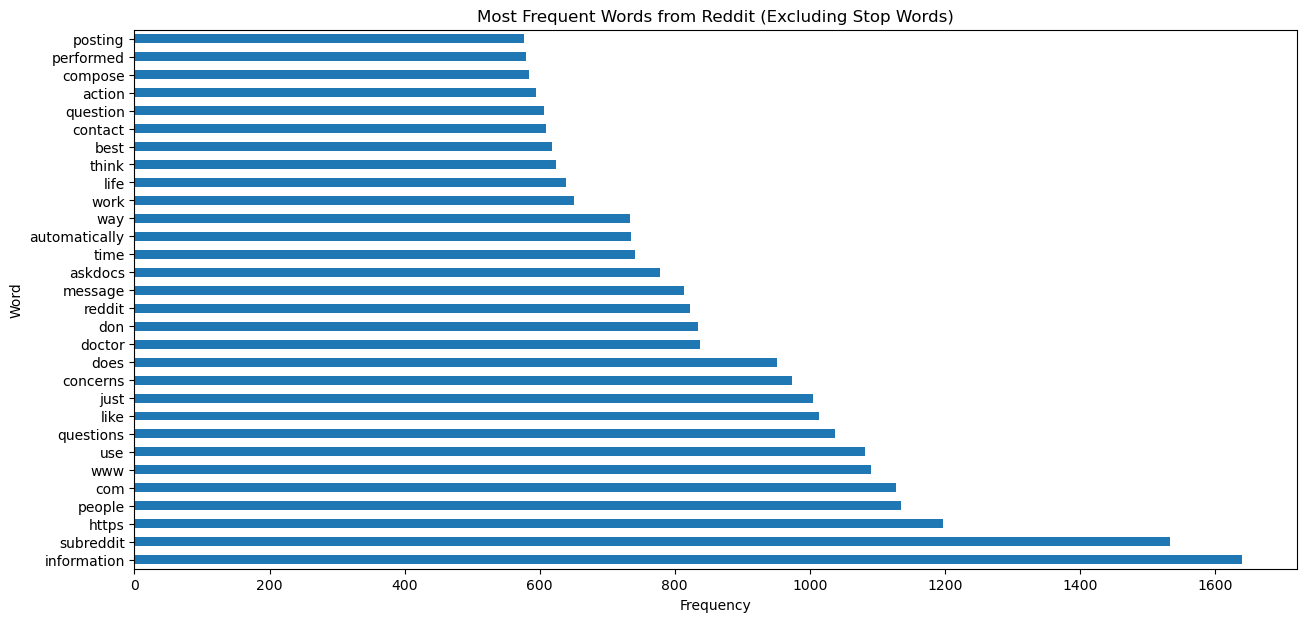

In [457]:
#Set figure size
plt.figure(figsize=(15,7))
#Plotting 30 most used words
df_reddit_cvec.sum().sort_values(ascending=False).head(30).plot(kind='barh')
plt.title("Most Frequent Words from Reddit (Excluding Stop Words)")
plt.xlabel('Frequency')
plt.ylabel('Word')

In [458]:
#Instantiate CVEC while excluding stop words
cvec = CountVectorizer(stop_words='english')
#Fit to column
cvec.fit(real['answers'])
#Transform column
top_answers = cvec.transform(real['answers'])
#Dataframe with transformed data
df_openai_cvec = pd.DataFrame(top_answers.todense(), columns = cvec.get_feature_names_out())
df_openai_cvec

,000,002,010,03,033,036,082,0m,10,100,...,zip,zipper,zippers,zocdoc,zone,zoonotic,zoos,zoster,zucchini,zwilling
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3479,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3480,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3481,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3482,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Text(0, 0.5, 'Word')

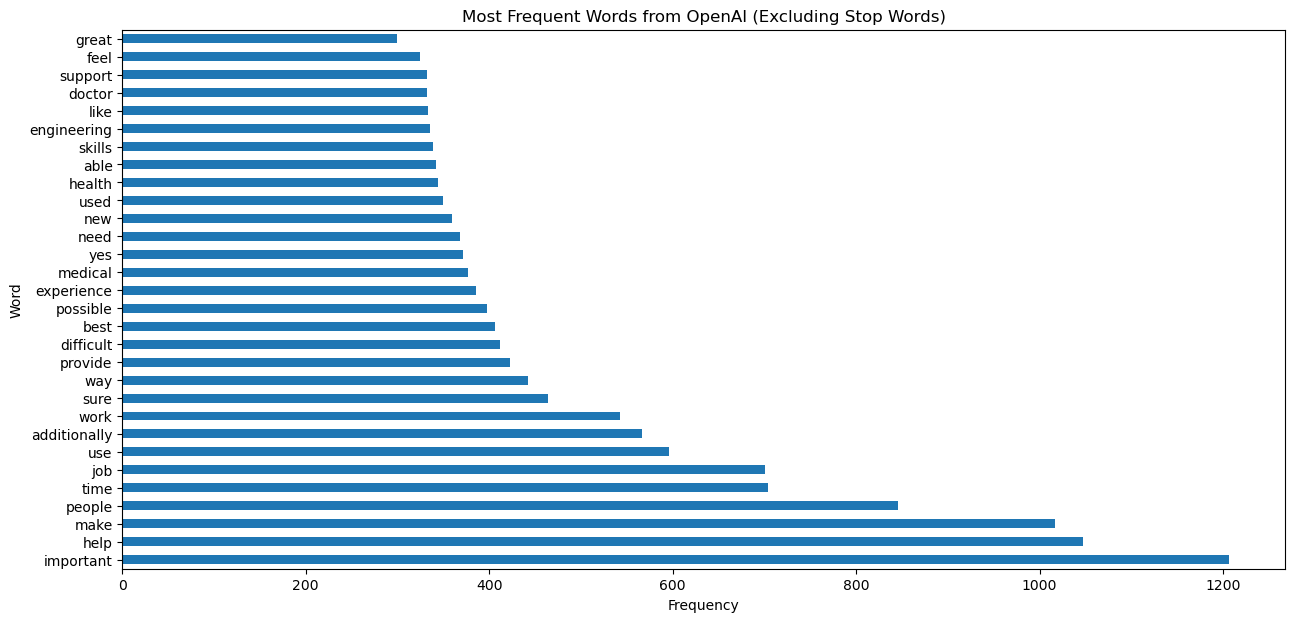

In [459]:
#Set figure size
plt.figure(figsize=(15,7))
#Plotting 30 most used words
df_openai_cvec.sum().sort_values(ascending=False).head(30).plot(kind='barh')
plt.title("Most Frequent Words from OpenAI (Excluding Stop Words)")
plt.xlabel('Frequency')
plt.ylabel('Word')

# Modelling
- Will focus on LogRegression and Bernoulli Naive Bayes as they are both good for classification problems, with both logregression and BNB in particular good for cases where the outcome is binary (human vs AI)

MODEL 1 - LOG REGRESSION + TFIDF

In [460]:
#Split data into predictive variables and target variable
X = df['answer']
y = df['who_from']

In [461]:
#Baseline
y.value_counts(normalize = True)

0    0.5
1    0.5
Name: who_from, dtype: float64

In [462]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Text(0.5, 1.0, 'TFIDFVectorizer: Number of occurences for given word')

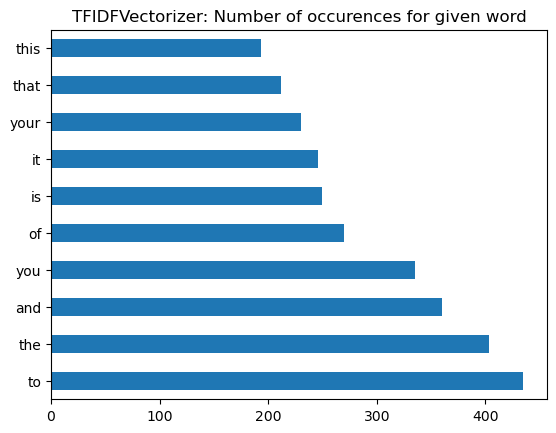

In [463]:
#Bar chart of word count
#Taken from lesson 2.05
tfidf = TfidfVectorizer()
# convert training data to dataframe
X_train_tfidf = pd.DataFrame(tfidf.fit_transform(X_train).todense(), 
                          columns=tfidf.get_feature_names_out())
# plot top occuring words
X_train_tfidf.sum().sort_values(ascending=False).head(10).plot(kind='barh');
plt.title('TFIDFVectorizer: Number of occurences for given word')

In [464]:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [465]:
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)

LogisticRegression()

In [466]:
y_pred = lr.predict(X_test_tfidf)

In [467]:
y_test.value_counts(normalize = True)

0    0.523673
1    0.476327
Name: who_from, dtype: float64

In [468]:
pd.Series(y_pred).value_counts(normalize = True)

0    0.517217
1    0.482783
dtype: float64

In [469]:
#Trying to get 
#https://www.datacamp.com/tutorial/understanding-logistic-regression-python
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.91      0.92       730
           1       0.90      0.92      0.91       664

    accuracy                           0.91      1394
   macro avg       0.91      0.91      0.91      1394
weighted avg       0.91      0.91      0.91      1394



In [470]:
#https://towardsdatascience.com/the-f1-score-bec2bbc38aa6
#F1 score is harmonic mean, average of precision and recall

In [471]:
#Building confusion matrix
#Referred to lesson 2.05
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

In [472]:
tn, fp, fn, tp

(666, 64, 55, 609)

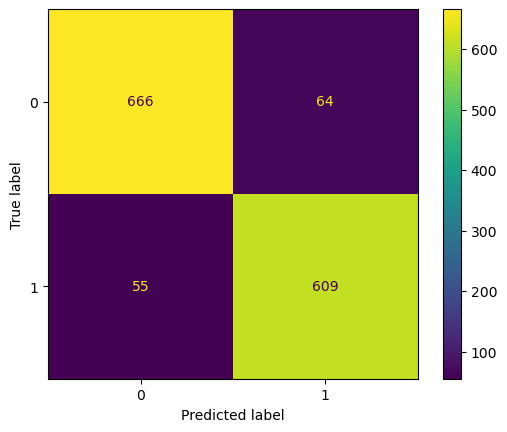

In [473]:
#Had trouble implementing confusion matrix to how it was done in lesson 2.05
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

In [474]:
lr.score(X_train_tfidf, y_train)

0.9610692500897022

In [475]:
lr.score(X_test_tfidf, y_test)

0.9146341463414634

MODEL 2 - BERNOULLI NAIVE BAYES + CVEC W/PIPELINE & GRIDSEARCH + STOPWORDS

In [476]:
#Split data into predictive variables and target variable
X = df['answer']
y = df['who_from']

In [477]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Text(0.5, 1.0, 'CountVectorizer: Number of occurences for given word')

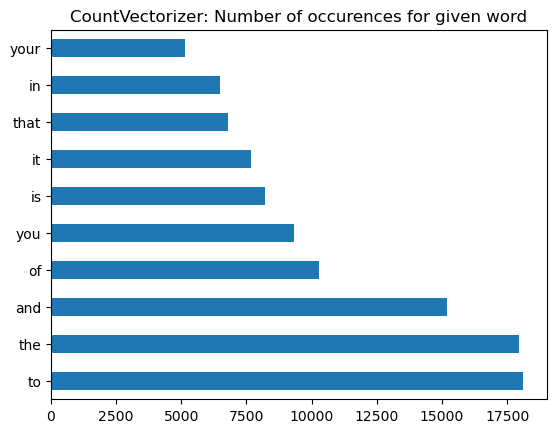

In [478]:
#Bar chart of word count
#Taken from lesson 2.05
cvec = CountVectorizer()
# convert training data to dataframe
X_train_cvec = pd.DataFrame(cvec.fit_transform(X_train).todense(), 
                          columns=cvec.get_feature_names_out())
# plot top occuring words
X_train_cvec.sum().sort_values(ascending=False).head(10).plot(kind='barh');
plt.title('CountVectorizer: Number of occurences for given word')

In [479]:
#Referred to lesson 2.05 and hackathon notes for the below
#Set up pipe
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('bnb', BernoulliNB())
])

In [480]:
#Using pipeline as model (for fun)
# Estimate how your model will perform on unseen data
cross_val_score(pipe, X_train, y_train, cv=3).mean() 

# Fit your model
pipe.fit(X_train, y_train)

# Training score
pipe.score(X_train, y_train)

# Test score
pipe.score(X_test, y_test)

0.7611190817790531

In [481]:
#Setting up stop words
nltk_stop = stopwords.words('english')

In [482]:
# Search over the following values of hyperparameters:

pipe_params = {
    'cvec__max_features' : [None, 1000], # Maximum number of features fit
    'cvec__min_df' : [1, 5, 10], # Minimum number of documents needed to include token
    'cvec__max_df' : [0.9, .95], # Maximum number of documents needed to include token
    'cvec__ngram_range' : [(1, 2), (1,1)], #Check (individual tokens) and also check (individual tokens and 2-grams)
    'cvec__stop_words' : ['english', None, nltk_stop] #Words to remove from text data
}

In [483]:
# Instantiate GridSearchCV.

gs = GridSearchCV(pipe, # what object are we optimizing?
                  pipe_params, # what parameters values are we searching?
                  cv = 5) # 5-fold cross-validation.

In [484]:
# Fit GridSearch to training data.
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('bnb', BernoulliNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [None, 1000],
                         'cvec__min_df': [1, 5, 10],
                         'cvec__ngram_range': [(1, 2), (1, 1)],
                         'cvec__stop_words': ['english', None,
                                              ['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                                               'hers', 'herself', 'it', "it's",
                                               'its', 'itself', ...]]})

In [485]:
#Check best score
gs.best_score_

0.7854323691138465

In [486]:
#Score on training data
gs.score(X_train, y_train)

0.8031933979189092

In [487]:
#Score on test data
gs.score(X_test, y_test)

0.7747489239598279

In [488]:
gs.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': None,
 'cvec__min_df': 5,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': None}

In [489]:
# Get predictions
preds = gs.predict(X_test)
# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

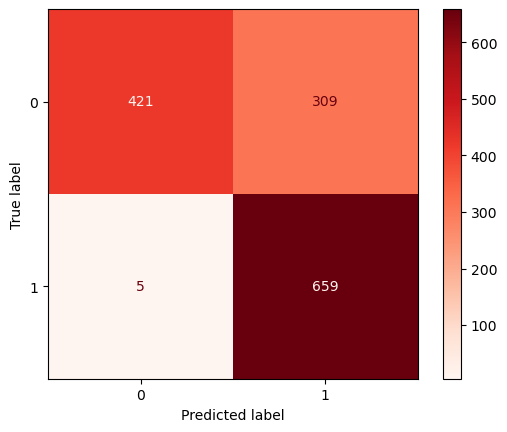

In [490]:
# View confusion matrix
ConfusionMatrixDisplay.from_estimator(gs, X_test, y_test, cmap='Reds', values_format='d');

In [491]:
pd.Series(preds).value_counts(normalize = True)

1    0.694405
0    0.305595
dtype: float64

MODEL 3: BERNOULLI NAIVE BAYES + TFIDF W/PIPELINE & GRIDSEARCH

In [492]:
#Split data into predictive variables and target variable
X = df['answer']
y = df['who_from']

In [493]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [494]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('bnb', BernoulliNB())
])

In [495]:
#Using pipeline as model (for fun)
# Estimate how your model will perform on unseen data
cross_val_score(pipe, X_train, y_train, cv=3).mean() 

# Fit your model
pipe.fit(X_train, y_train)

# Training score
pipe.score(X_train, y_train)

# Test score
pipe.score(X_test, y_test)

0.7611190817790531

In [496]:
pipe_params = {
    'tfidf__max_features' : [None, 5000], # Maximum number of features fit
    'tfidf__min_df' : [1, 5, 10], # Minimum number of documents needed to include token
    'tfidf__max_df' : [0.25, .5], # Maximum number of documents needed to include token
    'tfidf__ngram_range' : [(1, 2), (1,1)], #Check (individual tokens) and also check (individual tokens and 2-grams)
    'tfidf__stop_words' : ['english', None, nltk_stop] #Words to remove from text data
}

In [497]:
gs = GridSearchCV(pipe, # what object are we optimizing?
                  pipe_params, # what parameters values are we searching?
                  cv = 5) # 5-fold cross-validation.

In [498]:
# Fit GridSearch to training data.
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('bnb', BernoulliNB())]),
             param_grid={'tfidf__max_df': [0.25, 0.5],
                         'tfidf__max_features': [None, 5000],
                         'tfidf__min_df': [1, 5, 10],
                         'tfidf__ngram_range': [(1, 2), (1, 1)],
                         'tfidf__stop_words': ['english', None,
                                               ['i', 'me', 'my', 'myself', 'we',
                                                'our', 'ours', 'ourselves',
                                                'you', "you're", "you've",
                                                "you'll", "you'd", 'your',
                                                'yours', 'yourself',
                                                'yourselves', 'he', 'him',
                                                'his', 'himself', 'she',
                                                "she's", 'her', 'hers',
                                                'herself', 'it', "it's", 'its',
                                                'itself', ...]]})

In [499]:
#Check best score
gs.best_score_

0.7818441200859827

In [500]:
#Score on training data
gs.score(X_train, y_train)

0.8012199497667744

In [501]:
#Score on test data
gs.score(X_test, y_test)

0.7711621233859397

In [502]:
gs.best_params_

{'tfidf__max_df': 0.25,
 'tfidf__max_features': None,
 'tfidf__min_df': 5,
 'tfidf__ngram_range': (1, 1),
 'tfidf__stop_words': None}

In [503]:
# Get predictions
preds = gs.predict(X_test)
# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

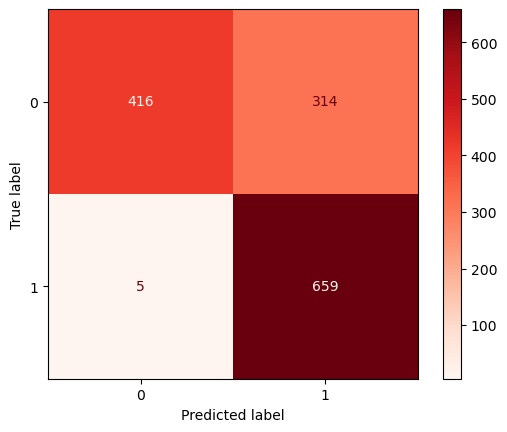

In [504]:
# View confusion matrix
ConfusionMatrixDisplay.from_estimator(gs, X_test, y_test, cmap='Reds', values_format='d');

In [505]:
y_test.value_counts(normalize = True)

0    0.523673
1    0.476327
Name: who_from, dtype: float64

In [506]:
pd.Series(preds).value_counts(normalize = True)

1    0.697991
0    0.302009
dtype: float64

MODEL 4: BERNOULLI NAIVE BAYES + CVEC

In [507]:
#Split data into predictive variables and target variable
X = df['answer']
y = df['who_from']

In [508]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [509]:
cvec = CountVectorizer()
X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec = cvec.transform(X_test)

In [510]:
bnb = BernoulliNB()
bnb.fit(X_train_cvec, y_train)

BernoulliNB()

In [511]:
y_pred = bnb.predict(X_test_cvec)

In [512]:
bnb.score(X_train_cvec, y_train)

0.8066020810907786

In [513]:
y_test.value_counts(normalize = True)

0    0.523673
1    0.476327
Name: who_from, dtype: float64

In [514]:
pd.Series(y_pred).value_counts(normalize = True)

1    0.709469
0    0.290531
dtype: float64

In [515]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.55      0.71       730
           1       0.67      0.99      0.80       664

    accuracy                           0.76      1394
   macro avg       0.83      0.77      0.75      1394
weighted avg       0.84      0.76      0.75      1394



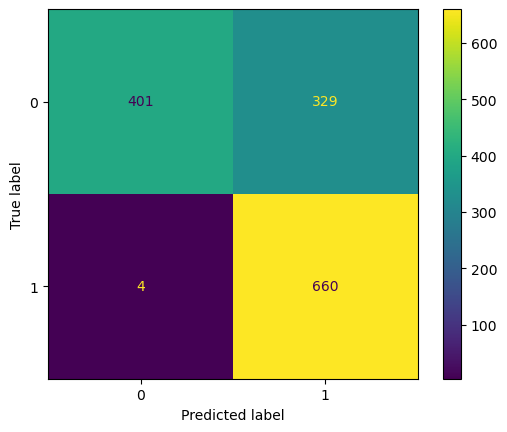

In [516]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

In [517]:
bnb.score(X_train_tfidf, y_train)

0.8066020810907786

In [518]:
bnb.score(X_test_tfidf, y_test)

0.7611190817790531

MODEL 5: BERNOULLI NAIVE BAYES + TFIDF

In [519]:
X = df['answer']
y = df['who_from']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

bnb = BernoulliNB()
bnb.fit(X_train_tfidf, y_train)

BernoulliNB()

In [520]:
y_pred = bnb.predict(X_test_tfidf)

In [521]:
bnb.score(X_train_tfidf, y_train)

0.8066020810907786

In [522]:
bnb.score(X_test_tfidf, y_test)

0.7611190817790531

In [523]:
y_test.value_counts(normalize = True)

0    0.523673
1    0.476327
Name: who_from, dtype: float64

In [524]:
pd.Series(y_pred).value_counts(normalize = True)

1    0.709469
0    0.290531
dtype: float64

In [525]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.55      0.71       730
           1       0.67      0.99      0.80       664

    accuracy                           0.76      1394
   macro avg       0.83      0.77      0.75      1394
weighted avg       0.84      0.76      0.75      1394



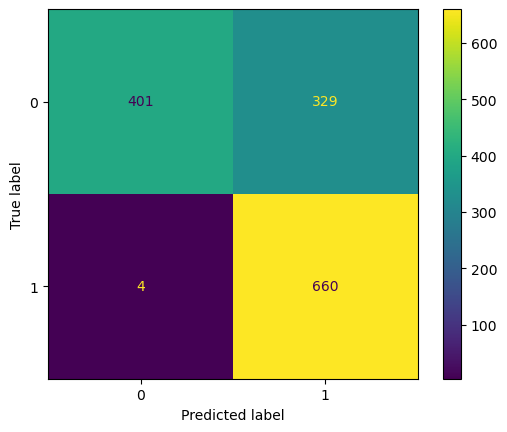

In [526]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

In [527]:
lr.score(X_train_tfidf, y_train)

0.9610692500897022

In [528]:
lr.score(X_test_tfidf, y_test)

0.9146341463414634

MODEL 6: BERNOULLI NAIVE BAYES + CVEC + PIPE + GRID
- Will explore stemming + lemmatization (both reduction of inflection from words)
    - Stemming: Words with same origin will get reduced to same form (which may not be a word)
        - https://www.geeksforgeeks.org/python-stemming-words-with-nltk/
    - Lemmatiztion: Words with same origin will get reduced to same form (reduced form will be a word)
        - https://www.codingninjas.com/studio/library/lemmatization
- https://www.mygreatlearning.com/blog/nltk-tutorial-with-python/#:~:text=NLTK%20is%20a%20standard%20python,language%20processing%20and%20computational%20linguistics.
- https://spacy.io/ may use (library for NLP)

In [529]:
"""
#https://medium.com/@makcedward/nlp-pipeline-lemmatization-part-3-4bfd7304957
#Above article shows both spacy and nltk uses
#https://towardsdatascience.com/elegant-text-pre-processing-with-nltk-in-sklearn-pipeline-d6fe18b91eb8
#Referred to above article for lemmatization process below
#Will use nltk lemmatization
lemmatizer = WordNetLemmatizer()

def NltkTextPreprocessor(text):
    words = nltk.word_tokenize(text)  #Tokenize text
    lemmatized_words = [] #Lemmatized words list
    for word in words: #Adding lemmatized word to lemmatized_words list
        lw = lemmatizer.lemmatize(word)
        lemmatized_words.append(lw)
    return ' '.join(lemmatized_words)

#https://queirozf.com/entries/scikit-learn-pipelines-custom-pipelines-and-pandas-integration
#Create custom transformer using lemmatization
lemmatizer = FunctionTransformer(NltkTextPreprocessor) #
"""

"\n#https://medium.com/@makcedward/nlp-pipeline-lemmatization-part-3-4bfd7304957\n#Above article shows both spacy and nltk uses\n#https://towardsdatascience.com/elegant-text-pre-processing-with-nltk-in-sklearn-pipeline-d6fe18b91eb8\n#Referred to above article for lemmatization process below\n#Will use nltk lemmatization\nlemmatizer = WordNetLemmatizer()\n\ndef NltkTextPreprocessor(text):\n    words = nltk.word_tokenize(text)  #Tokenize text\n    lemmatized_words = [] #Lemmatized words list\n    for word in words: #Adding lemmatized word to lemmatized_words list\n        lw = lemmatizer.lemmatize(word)\n        lemmatized_words.append(lw)\n    return ' '.join(lemmatized_words)\n\n#https://queirozf.com/entries/scikit-learn-pipelines-custom-pipelines-and-pandas-integration\n#Create custom transformer using lemmatization\nlemmatizer = FunctionTransformer(NltkTextPreprocessor) #\n"

Above I tried to implement lemmatization into my pipeline. Found various sites which said I could, but ultimately I wasn't able to figure it out. Will instead lemmatize my dataframe then do the modelling. 

In [530]:
X = df['answer']
y = df['who_from']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [531]:
#https://stackoverflow.com/questions/47557563/lemmatization-of-all-pandas-cells
#Referred to the above for lemmatization process of column
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

X = df['answer'].apply(lemmatize_text)

In [532]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),  # Vectorization
    ('bnb', BernoulliNB())  # Model
])

In [533]:
pipe_params = {
    'cvec__max_features': [None, 1000],
    'cvec__min_df': [1, 10, 50],
    'cvec__max_df': [0.25, 0.95],
    'cvec__ngram_range': [(1, 2), (1, 1)],
    'cvec__stop_words': ['english', None]
}

In [534]:
gs = GridSearchCV(pipe, # what object are we optimizing?
                  pipe_params, # what parameters values are we searching?
                  cv = 5) # 5-fold cross-validation.

In [535]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('bnb', BernoulliNB())]),
             param_grid={'cvec__max_df': [0.25, 0.95],
                         'cvec__max_features': [None, 1000],
                         'cvec__min_df': [1, 10, 50],
                         'cvec__ngram_range': [(1, 2), (1, 1)],
                         'cvec__stop_words': ['english', None]})

In [536]:
gs.best_score_

0.7813064865430597

In [537]:
gs.score(X_train, y_train)

0.7974524578399713

In [538]:
gs.score(X_test, y_test)

0.7776183644189383

In [539]:
gs.best_params_

{'cvec__max_df': 0.95,
 'cvec__max_features': None,
 'cvec__min_df': 10,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': None}

In [540]:
# Get predictions
preds = gs.predict(X_test)
# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

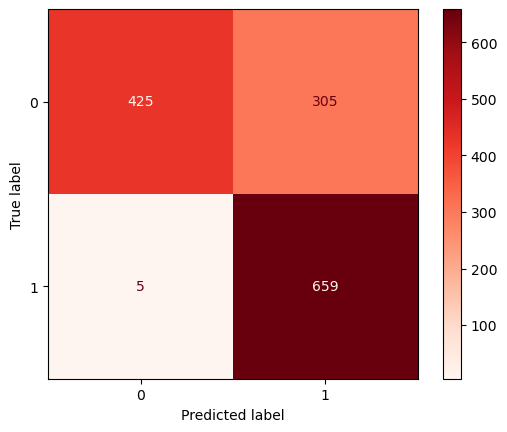

In [541]:
# View confusion matrix
ConfusionMatrixDisplay.from_estimator(gs, X_test, y_test, cmap='Reds', values_format='d');

In [542]:
pd.Series(preds).value_counts(normalize = True)

1    0.691535
0    0.308465
dtype: float64

MODEL 7: LOGREG + CVEC + PIPELINE + GRIDSEARCH + LEMMATIZATION

In [543]:
X = df['answer']
y = df['who_from']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [544]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

X = df['answer'].apply(lemmatize_text)

In [545]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),  # Vectorization
    ('lr', LogisticRegression(max_iter=1000)) #Raised max_iter as was getting an error that total no. of iterations reached limit
])
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [546]:
pipe_params = {
    'cvec__max_features': [None, 500, 1000, 5000],
    'cvec__min_df': [1, 10, 50],
    'cvec__max_df': [0.25, .5, 0.95],
    'cvec__ngram_range': [(1, 2), (1, 1)],
    'cvec__stop_words': ['english', None]
}

In [547]:
gs = GridSearchCV(pipe, # what object are we optimizing?
                  pipe_params, # what parameters values are we searching?
                  cv = 5) # 5-fold cross-validation.

In [548]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('lr',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'cvec__max_df': [0.25, 0.5, 0.95],
                         'cvec__max_features': [None, 500, 1000, 5000],
                         'cvec__min_df': [1, 10, 50],
                         'cvec__ngram_range': [(1, 2), (1, 1)],
                         'cvec__stop_words': ['english', None]})

In [549]:
gs.best_score_

0.9348750110698731

In [550]:
gs.score(X_train, y_train)

0.9912091855041263

In [551]:
gs.score(X_test, y_test)

0.9296987087517934

In [552]:
gs.best_params_

{'cvec__max_df': 0.5,
 'cvec__max_features': 5000,
 'cvec__min_df': 10,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': None}

In [553]:
# Get predictions
preds = gs.predict(X_test)
# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

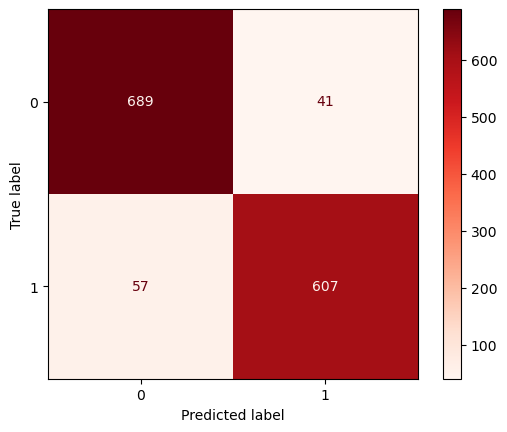

In [554]:
# View confusion matrix
ConfusionMatrixDisplay.from_estimator(gs, X_test, y_test, cmap='Reds', values_format='d');

In [555]:
pd.Series(preds).value_counts(normalize = True)

0    0.535151
1    0.464849
dtype: float64

MODEL 8: LOGREG + TFIDF + PIPELINE + GRIDSEARCH + STOPWORDS

In [557]:
X = df['answer']
y = df['who_from']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [558]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lr', LogisticRegression(max_iter = 1000))
])

In [559]:
pipe_params = {
    'tfidf__max_features' : [None, 100, 5000], # Maximum number of features fit
    'tfidf__min_df' : [1, 50, 10], # Minimum number of documents needed to include token
    'tfidf__max_df' : [0.25, .75, .9], # Maximum number of documents needed to include token
    'tfidf__ngram_range' : [(1, 2), (1,1)], #Check (individual tokens) and also check (individual tokens and 2-grams)
    'tfidf__stop_words' : ['english', None, nltk_stop] #Words to remove from text data
}

In [560]:
gs = GridSearchCV(pipe, # what object are we optimizing?
                  pipe_params, # what parameters values are we searching?
                  cv = 5) # 5-fold cross-validation.

In [561]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('lr',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'tfidf__max_df': [0.25, 0.75, 0.9],
                         'tfidf__max_features': [None, 100, 5000],
                         'tfidf__min_df': [1, 50, 10],
                         'tfidf__ngram_range': [(1, 2), (1, 1)],
                         'tfidf__stop_words': ['english', None,
                                               ['i', 'me', 'my', 'myself', 'we',
                                                'our', 'ours', 'ourselves',
                                                'you', "you're", "you've",
                                                "you'll", "you'd", 'your',
                                                'yours', 'yourself',
                                                'yourselves', 'he', 'him',
                                                'his', 'himself', 'she',
                                                "she's", 'her', 'hers',
                                                'herself', 'it', "it's", 'its',
                                                'itself', ...]]})

In [562]:
gs.best_score_

0.9282371126550789

In [563]:
gs.score(X_train, y_train)

0.9675278076785073

In [564]:
gs.score(X_test, y_test)

0.9225251076040172

In [565]:
gs.best_params_

{'tfidf__max_df': 0.25,
 'tfidf__max_features': None,
 'tfidf__min_df': 10,
 'tfidf__ngram_range': (1, 2),
 'tfidf__stop_words': None}

In [566]:
# Get predictions
preds = gs.predict(X_test)
# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

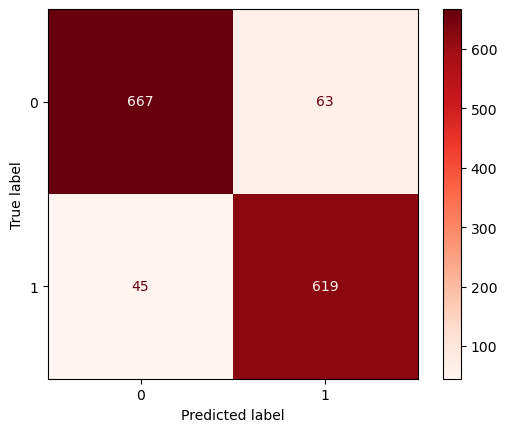

In [567]:
# View confusion matrix
ConfusionMatrixDisplay.from_estimator(gs, X_test, y_test, cmap='Reds', values_format='d');

In [568]:
preds = gs.best_estimator_.predict(X)
pd.Series(pred).value_counts(normalize = True)

1    0.505597
0    0.494403
dtype: float64